In [45]:
import pandas as pd
import numpy as np
import spacy
import scispacy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,Dropout, Embedding, Dense, Flatten, BatchNormalization, GRU
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz

In [38]:
# Load the SciSpaCy model
nlp = spacy.load("en_core_sci_sm")

In [39]:
# Read CSV file
df = pd.read_csv('data.csv')
df = df.dropna(subset=['text', 'label']) # Remove all rows with missing values
df['text'] = df['text'].str.replace(r'[^\w\s]+', '', regex=True) # Remove all punctuation
df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii') # Remove all non-ASCII chars
df['label'] = df['label'].str.lower()

In [40]:
# Preprocess text and extract features
def preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

df['text'] = df['text'].apply(preprocess_text)

In [41]:
df['text']

0       need add water drug vaccine ready administer p...
1       Hydroxychloroquine show effective rate treat D...
2       Fact Hydroxychloroquine show effective rate tr...
3       Corona virus man virus create Wuhan laboratory...
4       not billgates finance research Wuhan lab Coron...
                              ...                        
1159    study suggest ultraviolet ray slow virus wipe ...
1160    week medical journal report business traveler ...
1161    new report send White House science adviser sa...
1162    vaccine ultimate weapon coronavirus good route...
1163    develop deliver coronavirus vaccine test treat...
Name: text, Length: 1151, dtype: object

In [42]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [43]:
# Split data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.25, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)  

In [46]:
# Tokenize text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
# X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = max(len(seq) for seq in X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
# X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)


In [47]:
# Define the model architecture
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len),
    GRU(units=25),
    Dropout(0.5),
    BatchNormalization(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
27/27 [==============================] - 20s 657ms/step - loss: 0.6911 - accuracy: 0.5840 - val_loss: 0.6815 - val_accuracy: 0.5556
Epoch 2/50
27/27 [==============================] - 18s 659ms/step - loss: 0.4459 - accuracy: 0.8076 - val_loss: 0.6651 - val_accuracy: 0.6076
Epoch 3/50
27/27 [==============================] - 18s 650ms/step - loss: 0.2501 - accuracy: 0.9363 - val_loss: 0.6210 - val_accuracy: 0.7326
Epoch 4/50
27/27 [==============================] - 18s 650ms/step - loss: 0.1211 - accuracy: 0.9873 - val_loss: 0.5508 - val_accuracy: 0.7847
Epoch 5/50
27/27 [==============================] - 18s 653ms/step - loss: 0.0677 - accuracy: 0.9919 - val_loss: 0.4936 - val_accuracy: 0.7986
Epoch 6/50
27/27 [==============================] - 18s 653ms/step - loss: 0.0428 - accuracy: 0.9965 - val_loss: 0.4522 - val_accuracy: 0.8229
Epoch 7/50
27/27 [==============================] - 17s 641ms/step - loss: 0.0307 - accuracy: 0.9977 - val_loss: 0.4352 - val_accuracy: 0.8229

In [49]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

9/9 [==============================] - 1s 125ms/step - loss: 1.1019 - accuracy: 0.8368
Loss: 1.1019482612609863
Accuracy: 0.8368055820465088


In [52]:
# Predict labels
y_pred_probs = model.predict(X_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

9/9 [==============================] - 1s 121ms/step
Accuracy: 0.8368055555555556
Precision: 0.8896551724137931
Recall: 0.80625
F1 Score: 0.8459016393442623


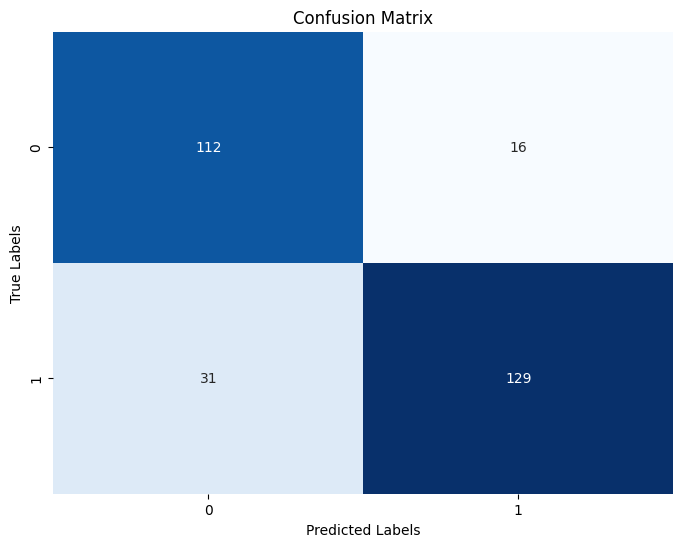

In [53]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()